In [2]:
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
import urllib.request
import datetime
import json
import numpy as np

['컨버스 런스타 하이크 하이' '데이브레이크페일아이보리' '아디다스 이지 부스트 700 MNVN' '컨버스 펑첸왕 투인원 척70'
 '아디다스 이지 퀀텀 틸 블루' '아디다스 이지 부스트 380 페퍼' '아디다스 이지 퀀텀 라이프스타일'
 '아디다스 이지 700 아자레스' '션우더스푼 슈퍼스타' '아디다스 이지 부스트 350v2 리넨' '컨버스 런스타 하이크스모크'
 '컨버스 키스 해링 런스타 하이크' '아디다스 이지 부스트 350 v2애쉬 스톤' '컨버스 디스이즈네버댓 척70'
 '컨버스 골프왕 척 70' '컨버스 다크쉐도우 터보웨폰' '컨버스트위스티드 리조트' '컨버스 런스타 하이크 콘크리트'
 '컨버스키스 해링 척 70 ' '컨버스 브레인 데드 척 70' '컨버스 칼하트 척 70' '아디다스 이지 슬라이드 본'
 '아디다스 이지 폼 러너 샌드' '아디다스 이지 폼 러너 문 그레이' '컨버스 반둘루 척 70' '아디다스 이지 부스트 700 썬'
 '아디다스 이지 부스트 350v2 시온' '컨버스 런스타 모션 하이 블랙' '아디다스 이지 700 사플라워'
 '아디다스 이지 데저트 부츠' '아디다스 레고 슈퍼스타' '아디다스 이지 부스트 700 브라이트 블루'
 '아디다스 이지 500 하이 미스트 스톤']
OK
OK
OK
OK
OK
OK
OK
OK
OK


<AxesSubplot:title={'center':'Naver Trend - Stock-Daily'}, xlabel='date'>

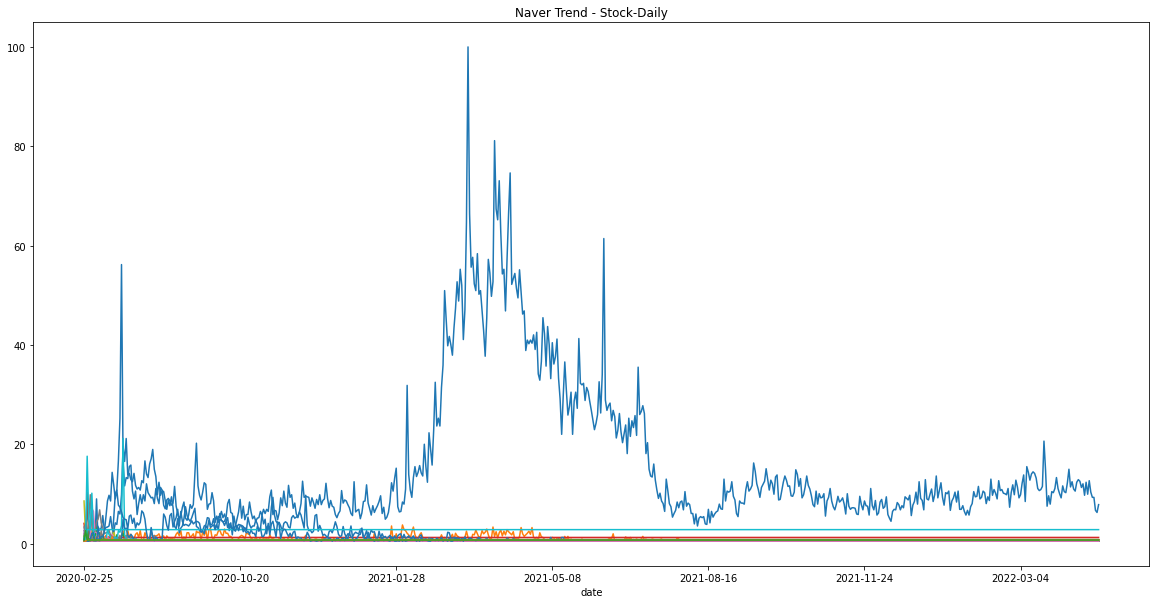

In [80]:
client_id = "bq2CyMn3Xbbz67r2VRUs"
client_secret = "FA5STDbaXL"

link = "https://openapi.naver.com/v1/datalab/search"
requested = urllib.request.Request(link)
requested.add_header("X-Naver-Client-Id",client_id)
requested.add_header("X-Naver-Client-Secret",client_secret)
requested.add_header("Content-Type","application/json")

#load dataset
df = pd.read_csv("duplication_result23.csv")
names = df.검색키워드.values
print(names)

#"{\"startDate\":\"2017-01-01\",\"endDate\":\"2017-04-30\",\"timeUnit\":\"month\",\"keywordGroups\":[{\"groupName\":\"한글\",\"keywords\":[\"한글\",\"korean\"]},{\"groupName\":\"영어\",\"keywords\":[\"영어\",\"english\"]}],\"device\":\"pc\",\"ages\":[\"1\",\"2\"],\"gender\":\"f\"}"
now = datetime.datetime.now()
now.strftime("%Y-%m-%d")
body_dict = {"startDate":"2020-01-01", #Set it as you want
               "endDate":"2022-04-23",
               "timeUnit":"date"}
v_list = [{"groupName" : i, "keywords" : [i]} for i in names]

#추가적 키워드
#df["대표자명"] = df["대표자명"].apply(lambda x: re.sub(r'\(.*\)', '', x))
#df["대표자명"]  = df["대표자명"].apply(lambda x: [re.compile('[^ㄱ-ㅣ가-힣]+').sub("",x)] if len(re.compile('[^ㄱ-ㅣ가-힣]+').sub("",x)) < 5 else re.findall(r"[\w']+", x))

#for i in range(0, df.shape[0]):
    #for j in df["대표자명"].values[i]:
        #if "대표" not in j and j!= "":
            #v_list[i]["keywords"].append(j) 
    


standard = v_list[0]
standard_keyword = standard["groupName"]
list_use = v_list[1:]

split_list = [list_use[i:i+4] for i in range(0, len(list_use), 4)]

for i in split_list:
    i.append(standard)


sample_body = body_dict
sample_body["keywordGroups"] = split_list[0]
sample_body = json.dumps(sample_body, ensure_ascii=False)
sample_response = urllib.request.urlopen(requested, data=sample_body.encode("utf-8-sig"))

code = sample_response.getcode() #응답 코드 확인
if code == 200: #무사히 요청이 완료됨되면
    sample_response_body = sample_response.read()
    sample_scraped = sample_response_body.decode("utf-8-sig")
    print("OK")
else: 
    print ("Error Code:", code)

sample_result = json.loads(sample_scraped)

for i in sample_result["results"] :
    if i["title"] == standard_keyword:
        sample_standard = i["data"]

#'2017-01-01' 의 값을 Standard로 사용
scale = sample_standard[0]["ratio"]

df = {}

df[standard_keyword] = np.array([i["ratio"] for i in sample_standard])
length = len(df[standard_keyword])
date = np.array([i["period"] for i in sample_standard])
for i in split_list:

    body_dict["keywordGroups"] = i
    body = json.dumps(body_dict, ensure_ascii=False)
    
    
    response = urllib.request.urlopen(requested, data=body.encode("utf-8-sig"))
    
    code = response.getcode() #응답 코드 확인
    if code == 200: #무사히 요청이 완료됨되면
        response_body = response.read()
        scraped = response_body.decode("utf-8")
        print("OK")
    else: 
        print ("Error Code:", code)
    
    
    
    result = json.loads(scraped)
    
    for i in result["results"]:
        if i["title"] == standard_keyword:
            compare = i["data"]
    compare = compare[0]["ratio"]
    
    scaling = scale/compare
    
    for i in result["results"]:
        if i["title"]!=standard_keyword:
            value = [j["ratio"]*scaling for j in i["data"]]
            if len(value)!=length:
                value+=np.abs(length-len(value)) * [value[-1]]
            df[i["title"]] = np.array(value)

df = pd.DataFrame(df)
df["date"] = date
df = df.set_index("date")

df.to_csv("ki17.csv", encoding = "utf-8-sig")

df.plot(title = "Naver Trend - Stock-Daily", figsize = (20, 10), legend = False)